In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
d = pd.read_json("results.json")
print("Total data points:", len(d))
d.rename(columns={"t1": "tgauss", "t2": "tdivfree", "t3": "tbareiss", "t4": "tmarkowitz"}, inplace=True)
d["ncells"] = d.neqs*d.nvars
npivots = np.min([d.neqs, d.nvars], axis=0)
d["n3"] = (npivots*(2*npivots*npivots - 3*(d.neqs + d.nvars - 1)*(npivots + 1) + 6*d.nvars*d.neqs - 2)/6)

Total data points: 18540


# Gauss vs Markowitz for numerical matrices

The conclusion is that Markowitz is better when `ncells > 200 && density < 0.5`.
Otherwise, Gauss is slightly better.

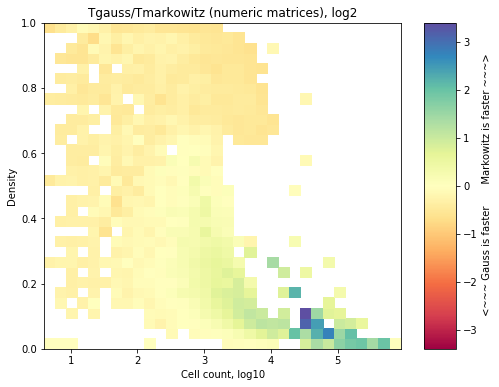

In [3]:
def meanplot(x, y, f, statistic='mean', xname=None, yname=None, fname=None, title=None):
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(x, y, f, statistic=statistic, bins=32)
    H = np.ma.masked_invalid(H)
    vrange=np.max(np.abs([np.max(H), np.min(H)]))
    plt.figure(figsize=(8, 6))
    pp = plt.pcolormesh(*np.meshgrid(xedges, yedges), H.T,
                        cmap=plt.cm.Spectral, vmin=-vrange, vmax=vrange)
    if xname: plt.xlabel(xname)
    if yname: plt.ylabel(yname)
    cb = plt.colorbar(pp, aspect=10)
    if title: plt.title(title)
    if fname: cb.set_label(fname)
    
dd = d[(d.nsymbols == 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tmarkowitz))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tmarkowitz),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Markowitz is faster ~~~>",
    title="Tgauss/Tmarkowitz (numeric matrices), log2")


# Gauss vs Bareiss and Divfree for numerical matrices

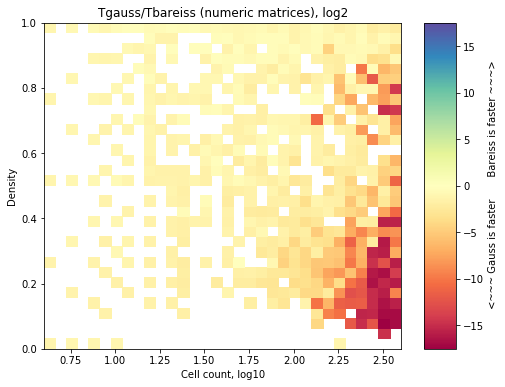

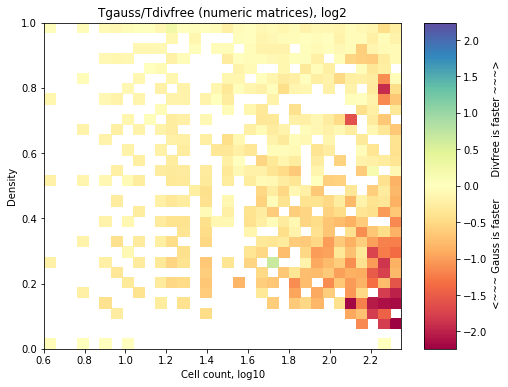

In [4]:
dd = d[(d.nsymbols == 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tbareiss))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tbareiss),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Bareiss is faster ~~~>",
    title="Tgauss/Tbareiss (numeric matrices), log2")

dd = d[(d.nsymbols == 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tdivfree))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tdivfree),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Divfree is faster ~~~>",
    title="Tgauss/Tdivfree (numeric matrices), log2")


The conclusion is to never use Bareiss or Divfree for numerical matrices.

# Gauss vs Markowitz for symbolic matrices

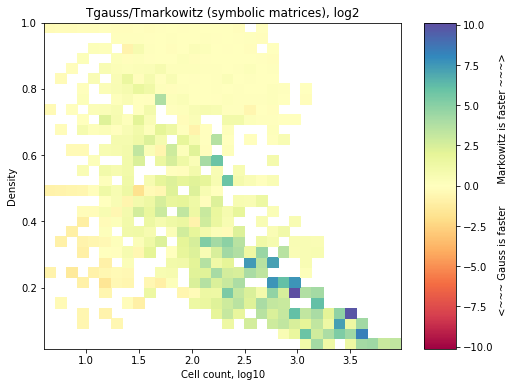

In [5]:
dd = d[(d.nsymbols > 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tmarkowitz))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tmarkowitz),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Markowitz is faster ~~~>",
    title="Tgauss/Tmarkowitz (symbolic matrices), log2")

In the small cell count region (`ncells <= 12`), Gauss is slightly faster, probably because of the higher fixed overhead in Markowitz. For fully dense matrices there's no difference. Otherwise Markowitz is always faster.

It would probably be more accurate to define the region where Gauss is faster as `ncells*density <= 12`, but as we'll see it doesn't really matter, as it's better to use Bareiss/Divfree in this region anyway.

Note that the graph above only shows the mean of `log(t1/t2)`, which somewhat hides the fact that the ratio is quite noisy, and it's possible to find matrices where Gauss happens to perform better than Markowitz even in high-`ncells` region. Maybe one could use more detailed matrix parameters (not just `ncells` and `density`) to tame this noise in the future.

To illustrate this point, let's look at the 10-th and the 90-th percentiles of the time ratio.

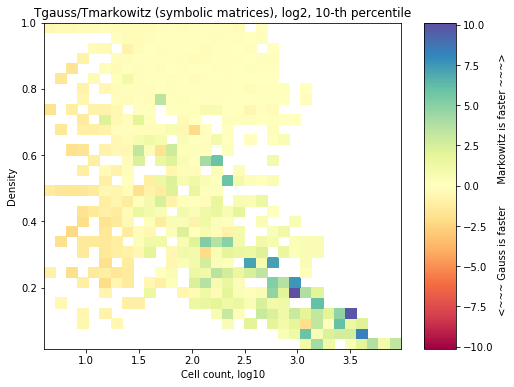

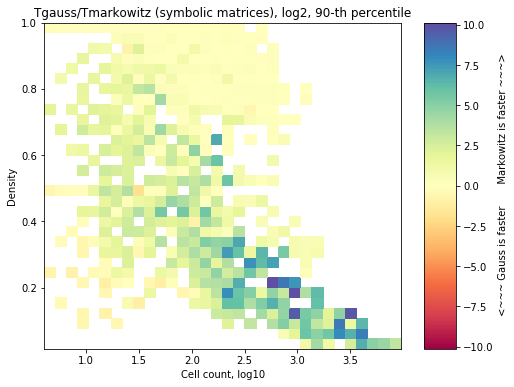

In [6]:
dd = d[(d.nsymbols > 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tmarkowitz))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tmarkowitz),
    statistic=lambda x: np.percentile(x, 10.0),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Markowitz is faster ~~~>",
    title="Tgauss/Tmarkowitz (symbolic matrices), log2, 10-th percentile")

dd = d[(d.nsymbols > 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tmarkowitz))]
meanplot(
    np.log10(dd.ncells), dd.density, np.log2(dd.tgauss/dd.tmarkowitz),
    statistic=lambda x: np.percentile(x, 90.0),
    xname="Cell count, log10",
    yname="Density",
    fname=" <~~~ Gauss is faster       Markowitz is faster ~~~>",
    title="Tgauss/Tmarkowitz (symbolic matrices), log2, 90-th percentile")

# Bareiss vs Divfree for symbolic matrices

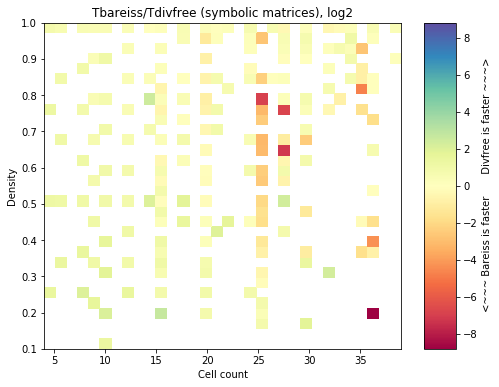

In [7]:
dd = d[(d.nsymbols > 1) & (~np.isnan(d.tbareiss)) & (~np.isnan(d.tdivfree)) & (d.ncells < 40)]
meanplot(
    dd.ncells, dd.density, np.log2(dd.tbareiss/dd.tdivfree),
    xname="Cell count",
    yname="Density",
    fname=" <~~~ Bareiss is faster       Divfree is faster ~~~>",
    title="Tbareiss/Tdivfree (symbolic matrices), log2")

As expected Divfree is faster than Bareiss for small matrices.
Perhaps surprisingly, is it faster up to `ncells <= 12`, mainly due to the sparse region, where it is faster for larger `ncells`.

# Gauss vs Bareiss/Divfree for symbolic matrices

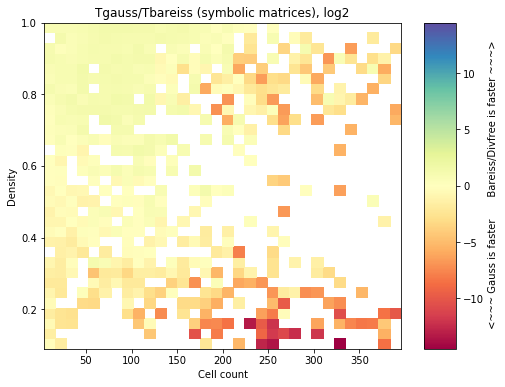

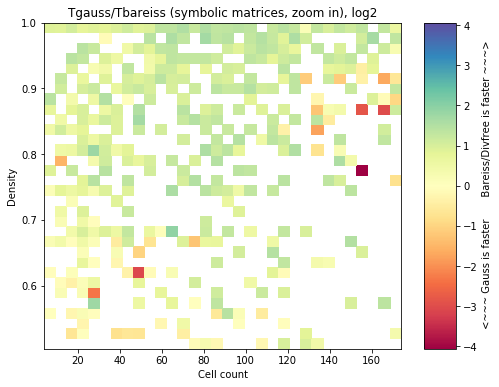

In [8]:
dd = d[(d.nsymbols > 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tbareiss))]
meanplot(
    dd.ncells, dd.density, np.log2(dd.tgauss/np.where(dd.ncells <= 12, dd.tdivfree, dd.tbareiss)),
    xname="Cell count",
    yname="Density",
    fname=" <~~~ Gauss is faster       Bareiss/Divfree is faster ~~~>",
    title="Tgauss/Tbareiss (symbolic matrices), log2")

# To zoom in a bit.
dd = d[(d.nsymbols > 0) & (~np.isnan(d.tgauss)) & (~np.isnan(d.tbareiss)) & (d.ncells < 175) & (d.density > 0.5)]
meanplot(
    dd.ncells, dd.density, np.log2(dd.tgauss/np.where(dd.ncells <= 12, dd.tdivfree, dd.tbareiss)),
    xname="Cell count",
    yname="Density",
    fname=" <~~~ Gauss is faster       Bareiss/Divfree is faster ~~~>",
    title="Tgauss/Tbareiss (symbolic matrices, zoom in), log2")

Bareiss/Divfree is faster than Gauss for `density > 0.6 && ncells < 120`.

# Conclusion

The overall recommendation is:
* For numeric matrices:
  * If `ncells > 200 && density < 0.5`: use Markowitz.
  * Otherwise: use Gauss.
* For symbolic matrices:
  * If `density > 0.6 && ncells < 120`:
    * If `ncells <= 12`: use Divfree.
    * Otherwise use Bareiss.
  * Otherwise: use Markowitz.